# Markowitz & CAPM Foundations

## Interpretation

Given many portfolios:

1.  **Efficient:** Portfolios on the upper boundary (the frontier) are efficient. You cannot get a higher return without accepting more risk.
2.  **Inefficient:** Portfolios *below* the curve. For any point here, there exists another portfolio directly above it with higher return for the same risk.
3.  **Impossible:** Portfolios *above* the curve are theoretically unattainable given the current set of assets and inputs.

## Exercise 1
Filter portfolios on the frontier, and plot the efficient frontier.

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ["AAPL","MSFT","GOOGL","AMZN","META","TSLA","NVDA","BRK-B","JPM","V",
"JNJ","WMT","PG","XOM","CVX","UNH","HD","BAC","KO","PFE",
"PEP","DIS","CSCO","ABT","CMCSA","NKE","MCD","ORCL","TMO","COST",
"ABBV","ACN","AVGO","TXN","QCOM","LIN","UPS","PM","BMY","LLY",
"AMD","HON","IBM","BA","CAT","RTX","AMGN","SPGI","GS","BLK",
"AXP","COP","SBUX","INTU","ADP","LMT","PLD","DE","ISRG","GE",
"SYK","NOW","SCHW","DUK","NEE","SO","TGT","MMC","ZTS","APD",
"ETN","FDX","NSC","CSX","ADSK","BDX","AON","AEP","EXC","ECL",
"MRK","GILD","MRNA","BNTX","NEM","FCX","RIO","BHP","VALE","GLD",
"SLV","TLT","IEF","SHY","LQD","HYG","SPY","QQQ","IWM","EFA"]

start_date = "2018-01-01"
end_date = "2024-12-31"

# Download prices
prices_df = pd.DataFrame()
for t in tickers:
    data_t = yf.download(t, start=start_date, end=end_date, progress=False, auto_adjust=False)
    prices_df[t] = data_t["Close"]

In [3]:
# Compute log returns
log_ret_df = np.log(prices_df / prices_df.shift(1)).dropna()

# Covariance matrix of daily log returns
cov_matrix = log_ret_df.cov()

In [4]:
def portfolio_volatility(weights, cov_matrix):
    """
    weights: 1D numpy array of shape (n_assets,)
    cov_matrix: pandas DataFrame or numpy array (n_assets x n_assets)
    returns annualized volatility
    """
    w = np.array(weights)
    cov = np.array(cov_matrix)
    var_daily = w.T @ cov @ w
    return np.sqrt(var_daily) * np.sqrt(252)

In [5]:
# Risk-Return Cloud
assets = log_ret_df.columns
n_assets = len(assets)

mean_daily_returns = log_ret_df.mean()
mean_annual_returns = mean_daily_returns * 252

def random_weights(n):
    w = np.random.rand(n)
    return w / w.sum()

n_portfolios = 5000
port_returns = []
port_vols = []
port_weights = []

for _ in range(n_portfolios):
    w = random_weights(n_assets)
    ret = np.dot(w, mean_annual_returns)
    vol = portfolio_volatility(w, cov_matrix)
    port_weights.append(w)
    port_returns.append(ret)
    port_vols.append(vol)

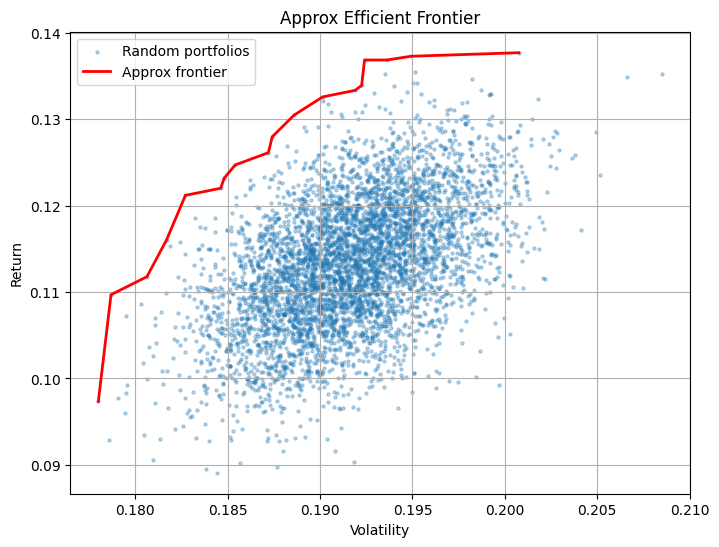

In [6]:
# Filter portfolios on the top of the frontier, and plot such frontier
# Convert to numpy arrays
R = np.array(port_returns)
V = np.array(port_vols)

# Sort by volatility
order = np.argsort(V)
V_sorted = V[order]
R_sorted = R[order]

frontier_vol = []
frontier_ret = []
current_max_ret = -1e9

for v, r in zip(V_sorted, R_sorted):
    if r > current_max_ret:
        frontier_vol.append(v)
        frontier_ret.append(r)
        current_max_ret = r

plt.figure(figsize=(8, 6))
plt.scatter(V, R, s=5, alpha=0.3, label="Random portfolios")
plt.plot(frontier_vol, frontier_ret, color="red", linewidth=2, label="Approx frontier")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.title("Approx Efficient Frontier")
plt.show()

### Questions

1. _Does the red curve roughly envelope the top-left part of the cloud?_

Yes, it does.

2. _Conceptually, why would an investor pick a point on this curve instead of below it?_

An investor would pick a point on the curve instead of below it because the curve represents the maximum possible returns for a given level of risk. Any point below the curve represents a lower level of risk for a lower level of returns.

# CAPM Conceptual: Market Risk vs Idiosyncratic Risk

## Capital Asset Pricing Model (CAPM)

The CAPM states that the expected return of an asset $i$ is:

$$E[R_i] = r_f + \beta_i (E[R_m] - r_f)$$

*   $r_f$: Risk-free rate
*   $E[R_m]$: Expected market return
*   $\beta_i$: Beta, representing the sensitivity of asset $i$ to market movements

## Risk Decomposition

Risk can be decomposed into two components:

1.  **Systematic Risk:** Market-wide risk that cannot be diversified away. This is captured by **Beta ($\beta$)**.
2.  **Idiosyncratic Risk:** Specific to the individual asset. This **can** be eliminated through diversification.

# Exercise 2
Compute beta and alpha estimate for a given stock and market

In [15]:

market = "SPY"
stock = "AAPL"
start_date = "2018-01-01"
end_date = "2024-12-31"

prices_m = yf.download(market, start=start_date, end=end_date, progress=False, auto_adjust=False)["Close"]
prices_s = yf.download(stock, start=start_date, end=end_date, progress=False, auto_adjust=False)["Close"]

log_ret_m = np.log(prices_m / prices_m.shift(1))
log_ret_s = np.log(prices_s / prices_s.shift(1))

# Align indices
df = pd.concat([log_ret_s, log_ret_m], axis=1).dropna()
df.columns = ["stock", "market"]

# Run linear regression: stock = a + b * market
import statsmodels.api as sm

X = sm.add_constant(df["market"]) # The slope is the beta, intercept is alpha estiamte
y = df["stock"] 
model = sm.OLS(y, X).fit()

beta = model.params["market"]  # The slope (Beta)
alpha = model.params["const"]  # The intercept (Alpha)
print(f"Alpha: {alpha:.5f}")
print(f"Beta: {beta:.5f}")

Alpha: 0.00046
Beta: 1.21472


### Questions

1. _Is beta > 1 or < 1? What does that say about volatility relative to the market?_

It is higher than 1, meaning that the stock is more volatile than the market.

2. _Is alpha significantly different from 0?_

No. The return was expected for the given risk taken.

# Estimating Beta & Rolling Beta

## Beta Instability & Rolling Beta

Beta is **not constant**. Over time, the relationship between an asset and the market can change due to various economic and company-specific factors.

**Rolling Beta:** To tackle this, we compute beta over a **moving window** (e.g., 60 days). This allows us to track how the asset's risk profile evolves over time rather than relying on a single static number.

## Exercise 3
Compute rolling beta over a window of 60 days.

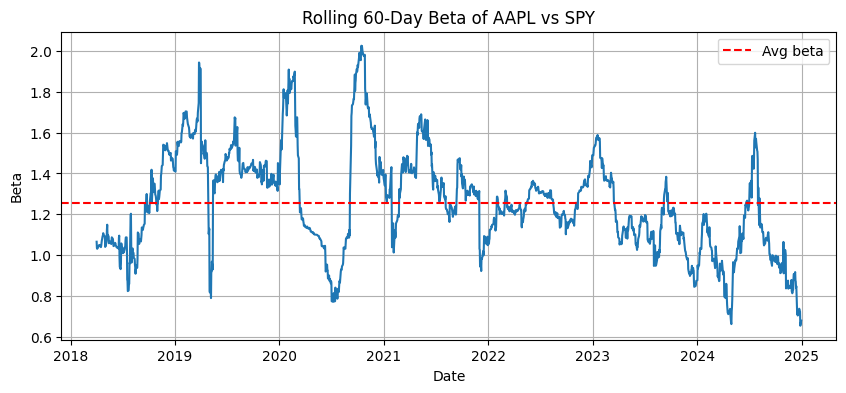

In [ ]:
window = 60
betas = []

for i in range(window, len(df)):
    window_data = df.iloc[i-window:i]
    X = sm.add_constant(window_data["market"])
    y = window_data["stock"]
    beta_i = sm.OLS(y, X).fit().params["market"]
    betas.append(beta_i)

beta_index = df.index[window:]
betas = pd.Series(betas, index=beta_index)

plt.figure(figsize=(10, 4))
plt.plot(betas.index, betas.values)
plt.axhline(y=betas.mean(), color='red', linestyle='--', label='Avg beta')
plt.title(f"Rolling {window}-Day Beta of {stock} vs {market}")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.grid(True)
plt.show()

### Questions

1. _Does beta fluctuate a lot?_

Yes, it does. The fluctuation is due to the market volatility. 

2. _In what periods does the stock seem more/less sensitive to the market?_

The stock seems more sensitive to the market during periods of high market volatility.

# CAPM Expected vs Realized Returns

## CAPM Expected Return

Using the CAPM formula, we can estimate the **expected annual return** of a stock $s$:

$$\hat{E}[R_s] = r_f + \beta_s (E[R_m] - r_f)$$

We can then compare this theoretical expectation with the **actual sample mean return** observed in our data.

**Key Takeaway:** CAPM is a *model*. It provides a theoretical framework for pricing risk, but it may or may not fit reality perfectly in every time period or for every asset.

## Exercise 4
Compute CAPM expected return vs realized return

In [29]:
rf_annual = 0.02  # assume 2% risk-free, adjust as you like
mean_m_annual = log_ret_m.dropna().values.mean() * 252
beta_est = model.params["market"]

capm_expected = rf_annual + beta_est * (mean_m_annual - rf_annual)
realized_stock = log_ret_s.dropna().values.mean() * 252

print(f"CAPM expected annual return for {stock}: {capm_expected:.4f}")
print(f"Realized annual return for {stock}: {realized_stock:.4f}")

CAPM expected annual return for AAPL: 0.1320
Realized annual return for AAPL: 0.2532


### Questions

1. _Is CAPM’s expected return close to realized?_

Not at all. This exemplifies the mismatch between the model and the real world.

2. _If not, what reasons can you think of (model error, sample period, noise…)?_

The main reason in this case is the sample period. The sample period is too short to capture the true relationship between the market and the stock. 

# Portfolio + CAPM Summary

## Exercise 5
Recap of CAPM vs realized returns.

In [31]:
tickers = ["SPY", "EFA", "EEM", "TLT", "GLD"]
market = "SPY"
start, end = "2015-01-01", "2024-12-31"

data = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)["Close"]
log_ret = np.log(data / data.shift(1)).dropna()

mean_daily = log_ret.mean()
mean_annual = mean_daily * 252
std_daily = log_ret.std()
vol_annual = std_daily * np.sqrt(252)

rf_annual = 0.02  # assume 2% RF
m = log_ret[market]
mean_m_annual = m.mean() * 252

betas = {}
for t in tickers:
    if t == market: 
        betas[t] = 1.0
        continue
    df = pd.concat([log_ret[t], m], axis=1).dropna()
    df.columns = ["asset", "market"]
    X = sm.add_constant(df["market"])
    y = df["asset"]
    beta = sm.OLS(y, X).fit().params["market"]
    betas[t] = beta

beta_series = pd.Series(betas)

capm_expected = rf_annual + beta_series * (mean_m_annual - rf_annual)

summary = pd.DataFrame({
    "mean_annual": mean_annual,
    "vol_annual": vol_annual,
    "beta": beta_series,
    "capm_expected": capm_expected
}).loc[tickers]

print(summary)

     mean_annual  vol_annual      beta  capm_expected
SPY     0.105451    0.177589  1.000000       0.105451
EFA     0.022215    0.175829  0.839773       0.091759
EEM     0.007926    0.208676  0.883869       0.095527
TLT    -0.037253    0.153257 -0.182520       0.004404
GLD     0.074814    0.141269  0.036187       0.023092


### Questions

1. _What kind of assets do you have (risk, beta, returns)?_

Mixed assets.

2. _How does diversification help according to your simulations?_

Combining SPY with low/negative‑beta assets (GLD, TLT) can reduce portfolio volatility and drawdowns, often giving better risk‑adjusted returns than any single asset.

3. _How well does CAPM describe your sample?_

Poorly: EFA/EEM/TLT earned much less than CAPM predicts, while GLD earned much more. Beta alone doesn’t explain realized returns in this period.